In [1]:
from functools import partial
from pathlib import Path
from gdsfactory.typings import ComponentSpec, ComponentReference, ComponentOrReference

import numpy as np
import gdsfactory as gf
import lnoi400

In [2]:
@gf.cell
def chip_frame(size: tuple[int, int] = (10000, 5000)):
    c = gf.get_component("chip_frame", size=size, center=(0, 0))
    return c


@gf.cell(check_ports=False)
def double_taper_array(
    cols: int = 1,
    rows: int = 16,
    pitch: int = (0, 127),  # micron
    input_ext: float = 10.0,
):
    double_taper = gf.get_component(
        "double_linear_inverse_taper",
        input_ext=input_ext,
    )

    dt_array = gf.Component()
    ref = dt_array << gf.components.array(
        double_taper, columns=cols, rows=rows, spacing=pitch
    )

    dt_ports = rename_ports(ref, keyword="o1")
    dt_array.add_ports(dt_ports)
    dt_array.auto_rename_ports()
    return dt_array


@gf.cell(check_ports=False)
def pad_array(
    cols: int = 16,
    rows: int = 2,
    pitch: tuple[float, float] = (300, 1000),  # micron
    pad_size: tuple[float, float] = (150.0, 200.0),
):
    pad_array = gf.Component()
    ref = pad_array << gf.components.array(
        gf.components.pad(size=pad_size, layer="TL"),
        columns=cols,
        rows=rows,
        spacing=pitch,
    )
    pad_ports = rename_ports(ref, keyword="e1")
    pad_array.add_ports(pad_ports)
    pad_array.auto_rename_ports()

    return pad_array


def rename_ports(
    component: ComponentOrReference,
    keyword: str = "o1",
) -> dict:
    ref_ports = component.ports.filter(regex=keyword)
    return ref_ports


# chip_layout = chip_frame()
# chip_layout

# dt_array = double_taper_array()
# dt_array.pprint_ports()
# dt_array.plot()

# rf_pads = pad_array()
# rf_pads.pprint_ports()
# rf_pads.plot()

# Defining the template

┏━━━━━━┳━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━┳━━━━━━━━┳━━━━━━━━━━━┓
┃ name ┃ width ┃ orientation ┃ layer ┃ center ┃ port_type ┃
┡━━━━━━╇━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━╇━━━━━━━━╇━━━━━━━━━━━┩
└──────┴───────┴─────────────┴───────┴────────┴───────────┘

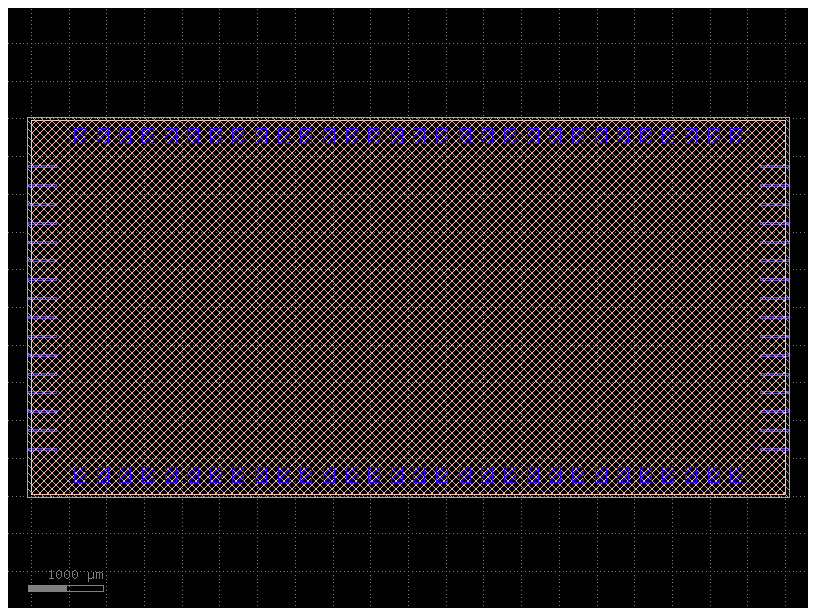

In [10]:
gf.clear_cache()
chip_template = gf.Component("Trilobite_WP2_ORCA_UCL_BAY")

# Add chip frame
chip_size = (10000, 5000)
chip_frame_ref = chip_template << chip_frame(size=chip_size)

# Add inverse taper
dt_east = double_taper_array(rows=16, pitch=(0, 250))
optical_east_ref = chip_template << dt_east
optical_east_ref.dmove(
    (
        chip_frame_ref.dxmin + chip_frame_ref.dxsize - optical_east_ref.dxsize,
        0.5 * (chip_frame_ref.dysize - optical_east_ref.dysize) + chip_frame_ref.dymin,
    )
)
# chip_template.add_ports(optical_east_ref)

dt_west = double_taper_array(rows=16, pitch=(0, 250))
optical_west_ref = chip_template << dt_west
optical_west_ref.mirror_x()
optical_west_ref.dmove(
    (
        chip_frame_ref.dxmin + optical_west_ref.dxsize,
        0.5 * (chip_frame_ref.dysize - optical_west_ref.dysize) + chip_frame_ref.dymin,
    )
)
# chip_template.add_ports(optical_west_ref)

# Add pads
pads_offset = 500
pads_ref = chip_template << pad_array(cols=30, pitch=(300, chip_size[1] - pads_offset))
pads_ref.dmove(
    (
        chip_frame_ref.dxmin + (chip_frame_ref.dxsize - pads_ref.dxsize) / 1.8,
        chip_frame_ref.dymin + (chip_frame_ref.dysize - pads_ref.dysize) / 1.15,
    )
)
# chip_template.add_ports(pads_ref)

# print((pads_ref.ports["e16"].dx, optical_east_ref.ports["o16"].dy))
east_loopback = gf.routing.route_single(
    chip_template,
    port1=optical_east_ref.ports["o1"],
    port2=optical_east_ref.ports["o16"],
    cross_section="xs_rwg1000",
    bend="L_turn_bend",
    # waypoints=[(pads_ref.ports["e16"].dx, optical_east_ref.ports["o16"].dy)],
)

chip_template.plot(return_fig=True)
chip_template.pprint_ports()
# chip_template.write_gds("chip_template.gds")